In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
import math 
import os
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

batch_size = 64

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(42)

dataset = "./COVID-19_Radiography_Dataset"

/home/ubuntu/anaconda3/envs/utec-bigdata-2022-1/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
cathegories = ['Normal/images', 'COVID/images', 'Viral Pneumonia/images', 'Lung_Opacity/images']
data_dir = os.path.join(dataset)

data = []

for category in cathegories:
    for img in os.listdir(os.path.join(data_dir, category)):
        data.append([category + '/' + img, category])

"""
Creacion de dataset con las imagenes, no se usan las mascaras
"""

data = pd.DataFrame(data, columns = ['img', 'category'])
data['path'] = dataset + '/' + data['img']
data['category'] = data['category'].map({'Normal/images': 0, 'COVID/images': 1, 'Viral Pneumonia/images': 2, 'Lung_Opacity/images': 3})
data = data[['path', 'category']]
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data.head()
data_np = data.to_numpy()

In [3]:
print(torch.tensor(cv2.imread(data_np[1,0],0).shape))

tensor([299, 299])


In [4]:
#Obtenido de https://discuss.pytorch.org/t/simple-efficient-way-to-create-dataset/65178
"""
Se crea un clase Dataset para usarla dentro del entrenamiento de los modelos CNN
"""
class MyDataClass(Dataset):
    def __init__(self, array_np, transform=None):
        super(MyDataClass, self).__init__()
        self.data = array_np   

    def __getitem__(self, idx):
        img = cv2.imread(self.data[idx,0],0)
        img = cv2.resize(img, (50, 50))
        x = torch.tensor(img)
        y = torch.tensor(self.data[idx,1])
        return x, y

    def __len__(self):
        return (self.data.shape[0])

x = cv2.imread(data_np[1][0], 0)
y = data_np[1][1]
X_train, X_rest, y_train, y_rest = train_test_split(data_np[:,0], data_np[:,1], test_size=0.3, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.33, shuffle=True)

train = np.c_[X_train, y_train]
validation = np.c_[X_val, y_val]
test = np.c_[X_test, y_test]

train_loader = MyDataClass(train)
test_loader = MyDataClass(test)
validation_loader =  MyDataClass(validation)

train_loader = torch.utils.data.DataLoader(dataset=train_loader, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_loader, batch_size=batch_size, shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_loader, batch_size=batch_size, shuffle=False)


In [4]:
num_classes = 4
learning_rate = 0.001
num_epochs = 20


In [12]:
num_classes = 4
learning_rate = 0.001
num_epochs = 20

"""
Modelo de CNN 2 capas
"""
class CNN(nn.Module ):
  def __init__ (self , num_classes =4):
    super (CNN , self).__init__ ()
    self. layer1 = nn.Sequential (
      nn.Conv2d ( in_channels =1, out_channels =16, kernel_size =3, stride =1, padding =2) ,
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self. layer2 = nn. Sequential (
      nn.Conv2d (in_channels=16, out_channels=32, kernel_size =5, stride =1, padding =2) ,
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self.fc = nn.Linear (13*13*32 , num_classes )

  def forward (self , x):
    out = self. layer1 (x)
    out = self. layer2 (out)
    out = out. reshape (out.size (0) , -1)
    out = self.fc(out)
    return out

In [17]:
"""
Entrenamiento para los modelos
"""

def train(model, optimizer, loos_fn, num_epochs, train_loader):
  loss_vals = []
  running_loss =0.0
  # train the model
  total_step = len(train_loader)

  list_loss= []
  list_time = []
  j=0

  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      images = torch.unsqueeze(images, dim=1)
      images = images.float()      
      # forward 
      output = model(images)
      loss   = loos_fn(output, labels)
      # change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      list_time.append(j)
      j+=1
              
      if (i+1) % 100 == 0:
        list_loss.append(loss.item())
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
              
  print('Finished Training Trainset')
  return list_loss


In [14]:
"""
Entrenamiento de CNN 2 capas
"""
model         = CNN().to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

model.fc.weight

list_loss = train(model,optimizer,loss_fn,20, train_loader)

Epoch [1/20], Step [100/232], Loss: 0.9926
Epoch [1/20], Step [200/232], Loss: 0.7076
Epoch [2/20], Step [100/232], Loss: 0.5479
Epoch [2/20], Step [200/232], Loss: 0.6863
Epoch [3/20], Step [100/232], Loss: 0.5826
Epoch [3/20], Step [200/232], Loss: 0.7606
Epoch [4/20], Step [100/232], Loss: 0.5663
Epoch [4/20], Step [200/232], Loss: 0.5993
Epoch [5/20], Step [100/232], Loss: 0.6115
Epoch [5/20], Step [200/232], Loss: 0.5754
Epoch [6/20], Step [100/232], Loss: 0.5501
Epoch [6/20], Step [200/232], Loss: 0.7001
Epoch [7/20], Step [100/232], Loss: 0.5072
Epoch [7/20], Step [200/232], Loss: 0.6855
Epoch [8/20], Step [100/232], Loss: 0.5315
Epoch [8/20], Step [200/232], Loss: 0.4598
Epoch [9/20], Step [100/232], Loss: 0.4802
Epoch [9/20], Step [200/232], Loss: 0.3372
Epoch [10/20], Step [100/232], Loss: 0.3683
Epoch [10/20], Step [200/232], Loss: 0.4542
Epoch [11/20], Step [100/232], Loss: 0.5271
Epoch [11/20], Step [200/232], Loss: 0.4112
Epoch [12/20], Step [100/232], Loss: 0.3709
Epoch 

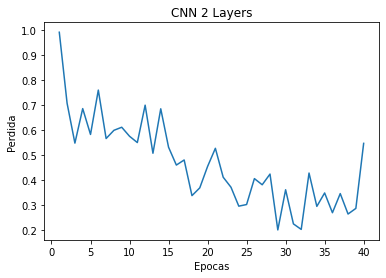

In [15]:
"""
Dibujo de perdida
"""

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("CNN 2 Layers")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)





In [16]:
"""
Pruebas para precision
"""
with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 82.72900763358778 %


Epoch [1/20], Step [100/232], Loss: 0.8812
Epoch [1/20], Step [200/232], Loss: 0.7507
Epoch [2/20], Step [100/232], Loss: 0.5693
Epoch [2/20], Step [200/232], Loss: 0.4985
Epoch [3/20], Step [100/232], Loss: 0.4364
Epoch [3/20], Step [200/232], Loss: 0.4856
Epoch [4/20], Step [100/232], Loss: 0.3835
Epoch [4/20], Step [200/232], Loss: 0.4077
Epoch [5/20], Step [100/232], Loss: 0.4526
Epoch [5/20], Step [200/232], Loss: 0.2963
Epoch [6/20], Step [100/232], Loss: 0.3669
Epoch [6/20], Step [200/232], Loss: 0.2666
Epoch [7/20], Step [100/232], Loss: 0.4467
Epoch [7/20], Step [200/232], Loss: 0.2816
Epoch [8/20], Step [100/232], Loss: 0.3409
Epoch [8/20], Step [200/232], Loss: 0.3496
Epoch [9/20], Step [100/232], Loss: 0.2155
Epoch [9/20], Step [200/232], Loss: 0.3724
Epoch [10/20], Step [100/232], Loss: 0.2943
Epoch [10/20], Step [200/232], Loss: 0.4144
Epoch [11/20], Step [100/232], Loss: 0.1941
Epoch [11/20], Step [200/232], Loss: 0.3525
Epoch [12/20], Step [100/232], Loss: 0.2229
Epoch 

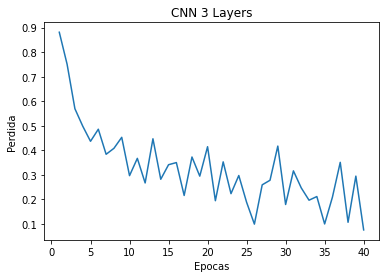

In [17]:
class CNN_3L(nn.Module ):
  def __init__ (self , num_classes =4):
    super (CNN_3L , self).__init__ ()
    self. layer1 = nn.Sequential (
      nn.Conv2d ( in_channels =1, out_channels =16, kernel_size =3, stride =1, padding =2) ,
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self. layer2 = nn. Sequential (
      nn.Conv2d (in_channels=16, out_channels=32, kernel_size =5, stride =1, padding =2) ,
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self. layer3 = nn. Sequential (
      nn.Conv2d (in_channels=32, out_channels=64, kernel_size =3, stride =1, padding =2) ,
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self.fc = nn.Linear (7*7*64 , num_classes )

  def forward (self , x):
    out = self. layer1 (x)
    out = self. layer2 (out)
    out = self. layer3 (out)
    out = out. reshape (out.size (0) , -1)
    out = self.fc(out)
    return out

model         = CNN_3L().to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

model.fc.weight

list_loss = train(model,optimizer,loss_fn,20, train_loader)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("CNN 3 Layers")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)



In [18]:
with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 84.30343511450381 %


Epoch [1/20], Step [100/232], Loss: 0.6085
Epoch [1/20], Step [200/232], Loss: 0.5610
Epoch [2/20], Step [100/232], Loss: 0.4734
Epoch [2/20], Step [200/232], Loss: 0.7003
Epoch [3/20], Step [100/232], Loss: 0.4635
Epoch [3/20], Step [200/232], Loss: 0.3008
Epoch [4/20], Step [100/232], Loss: 0.2926
Epoch [4/20], Step [200/232], Loss: 0.3961
Epoch [5/20], Step [100/232], Loss: 0.4966
Epoch [5/20], Step [200/232], Loss: 0.4478
Epoch [6/20], Step [100/232], Loss: 0.4002
Epoch [6/20], Step [200/232], Loss: 0.3698
Epoch [7/20], Step [100/232], Loss: 0.2363
Epoch [7/20], Step [200/232], Loss: 0.1936
Epoch [8/20], Step [100/232], Loss: 0.1600
Epoch [8/20], Step [200/232], Loss: 0.2852
Epoch [9/20], Step [100/232], Loss: 0.1624
Epoch [9/20], Step [200/232], Loss: 0.2004
Epoch [10/20], Step [100/232], Loss: 0.1510
Epoch [10/20], Step [200/232], Loss: 0.2794
Epoch [11/20], Step [100/232], Loss: 0.4027
Epoch [11/20], Step [200/232], Loss: 0.1283
Epoch [12/20], Step [100/232], Loss: 0.1969
Epoch 

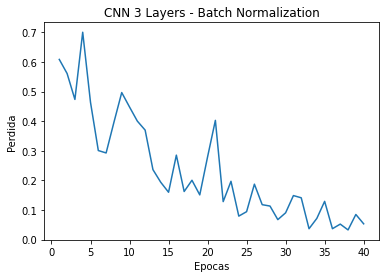

In [19]:
class CNN_3L_norm(nn.Module ):
  def __init__ (self , num_classes =4):
    super (CNN_3L_norm , self).__init__ ()
    self. layer1 = nn.Sequential (
      nn.Conv2d ( in_channels =1, out_channels =16, kernel_size =3, stride =1, padding =2) ,
      nn.BatchNorm2d(16),
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self. layer2 = nn. Sequential (
      nn.Conv2d (in_channels=16, out_channels=32, kernel_size =5, stride =1, padding =2) ,
      nn.BatchNorm2d(32),
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self. layer3 = nn. Sequential (
      nn.Conv2d (in_channels=32, out_channels=64, kernel_size =3, stride =1, padding =2) ,
      nn.BatchNorm2d(64),
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self.fc = nn.Linear (3136 , num_classes )

  def forward (self , x):
    out = self. layer1 (x)
    out = self. layer2 (out)
    out = self. layer3 (out)
    out = out. reshape (out.size (0) , -1)
    out = self.fc(out)
    return out

model         = CNN_3L_norm().to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

model.fc.weight

list_loss = train(model,optimizer,loss_fn,20, train_loader)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("CNN 3 Layers - Batch Normalization")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)



In [20]:
with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 86.25954198473282 %


Epoch [1/20], Step [100/232], Loss: 0.7039
Epoch [1/20], Step [200/232], Loss: 0.5082
Epoch [2/20], Step [100/232], Loss: 0.5962
Epoch [2/20], Step [200/232], Loss: 0.4946
Epoch [3/20], Step [100/232], Loss: 0.5481
Epoch [3/20], Step [200/232], Loss: 0.4319
Epoch [4/20], Step [100/232], Loss: 0.4816
Epoch [4/20], Step [200/232], Loss: 0.4610
Epoch [5/20], Step [100/232], Loss: 0.4955
Epoch [5/20], Step [200/232], Loss: 0.4370
Epoch [6/20], Step [100/232], Loss: 0.3900
Epoch [6/20], Step [200/232], Loss: 0.5157
Epoch [7/20], Step [100/232], Loss: 0.4068
Epoch [7/20], Step [200/232], Loss: 0.5178
Epoch [8/20], Step [100/232], Loss: 0.3640
Epoch [8/20], Step [200/232], Loss: 0.3159
Epoch [9/20], Step [100/232], Loss: 0.2556
Epoch [9/20], Step [200/232], Loss: 0.3671
Epoch [10/20], Step [100/232], Loss: 0.4067
Epoch [10/20], Step [200/232], Loss: 0.2909
Epoch [11/20], Step [100/232], Loss: 0.2979
Epoch [11/20], Step [200/232], Loss: 0.2134
Epoch [12/20], Step [100/232], Loss: 0.1656
Epoch 

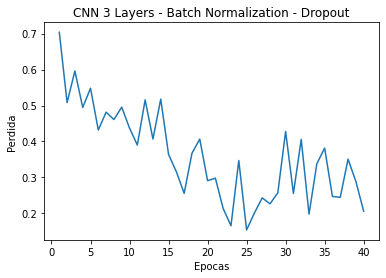

In [21]:
class CNN_3L_norm_drop(nn.Module ):
  def __init__ (self , num_classes =4):
    super (CNN_3L_norm_drop , self).__init__ ()
    self. layer1 = nn.Sequential (
      nn.Conv2d ( in_channels =1, out_channels =16, kernel_size =3, stride =1, padding =2) ,
      nn.BatchNorm2d(16),
      nn.Dropout(0.5),
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self. layer2 = nn. Sequential (
      nn.Conv2d (in_channels=16, out_channels=32, kernel_size =5, stride =1, padding =2) ,
      nn.BatchNorm2d(32),
      nn.Dropout(0.5),
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self. layer3 = nn. Sequential (
      nn.Conv2d (in_channels=32, out_channels=64, kernel_size =3, stride =1, padding =2) ,
      nn.BatchNorm2d(64),
      nn.Dropout(0.5),
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self.fc = nn.Linear (3136 , num_classes )

  def forward (self , x):
    out = self. layer1 (x)
    out = self. layer2 (out)
    out = self. layer3 (out)
    out = out. reshape (out.size (0) , -1)
    out = self.fc(out)
    return out

model         = CNN_3L_norm_drop().to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

model.fc.weight

list_loss = train(model,optimizer,loss_fn,20, train_loader)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("CNN 3 Layers - Batch Normalization - Dropout")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)



In [22]:
with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 88.5973282442748 %


Epoch [1/20], Step [100/232], Loss: 0.5043
Epoch [1/20], Step [200/232], Loss: 0.6300
Epoch [2/20], Step [100/232], Loss: 0.3202
Epoch [2/20], Step [200/232], Loss: 0.4106
Epoch [3/20], Step [100/232], Loss: 0.3734
Epoch [3/20], Step [200/232], Loss: 0.3365
Epoch [4/20], Step [100/232], Loss: 0.3321
Epoch [4/20], Step [200/232], Loss: 0.3858
Epoch [5/20], Step [100/232], Loss: 0.3635
Epoch [5/20], Step [200/232], Loss: 0.5017
Epoch [6/20], Step [100/232], Loss: 0.2521
Epoch [6/20], Step [200/232], Loss: 0.3554
Epoch [7/20], Step [100/232], Loss: 0.2497
Epoch [7/20], Step [200/232], Loss: 0.1763
Epoch [8/20], Step [100/232], Loss: 0.2270
Epoch [8/20], Step [200/232], Loss: 0.1687
Epoch [9/20], Step [100/232], Loss: 0.3177
Epoch [9/20], Step [200/232], Loss: 0.2353
Epoch [10/20], Step [100/232], Loss: 0.1951
Epoch [10/20], Step [200/232], Loss: 0.1999
Epoch [11/20], Step [100/232], Loss: 0.1505
Epoch [11/20], Step [200/232], Loss: 0.0617
Epoch [12/20], Step [100/232], Loss: 0.2426
Epoch 

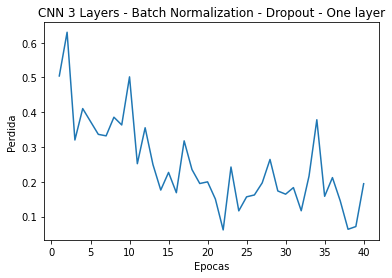

In [23]:
class CNN_3L_norm_drop2(nn.Module ):
  def __init__ (self , num_classes =4):
    super (CNN_3L_norm_drop2 , self).__init__ ()
    self. layer1 = nn.Sequential (
      nn.Conv2d ( in_channels =1, out_channels =16, kernel_size =3, stride =1, padding =2) ,
      nn.BatchNorm2d(16),
      nn.Dropout(0.5),
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self. layer2 = nn. Sequential (
      nn.Conv2d (in_channels=16, out_channels=32, kernel_size =5, stride =1, padding =2) ,
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self. layer3 = nn. Sequential (
      nn.Conv2d (in_channels=32, out_channels=64, kernel_size =3, stride =1, padding =2) ,
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self.fc = nn.Linear (3136 , num_classes )

  def forward (self , x):
    out = self. layer1 (x)
    out = self. layer2 (out)
    out = self. layer3 (out)
    out = out. reshape (out.size (0) , -1)
    out = self.fc(out)
    return out

model         = CNN_3L_norm_drop2().to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

model.fc.weight

list_loss = train(model,optimizer,loss_fn,20, train_loader)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("CNN 3 Layers - Batch Normalization - Dropout - One layer")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)




In [24]:
with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 86.92748091603053 %


In [8]:
def train_stop(model, optimizer, loos_fn, num_epochs, train_loader, validation_loader, patience):
  loss_vals = []
  running_loss =0.0
  criterion = nn.CrossEntropyLoss()
  
  # train the model
  total_step = len(train_loader)

  list_loss= []
  list_time = []
  j=0
  loss_before = 1000000
  sto = False
  for epoch in range(num_epochs):
    model.train() 
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      im = torch.unsqueeze(images, dim=1)
      im = im.float()
      # forward 
      output = model(im)
      loss   = loos_fn(output, labels)
      # change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      
      list_time.append(j)
      j+=1

      if (j+1) % 100 == 0:
              list_loss.append(loss.item())
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, j+1, total_step, loss.item()))

    valid_losses = []
    model.eval()

    for (images, labels) in (validation_loader):
      images = images.to(device)
      labels = labels.to(device)
      im = torch.unsqueeze(images, dim=1)
      im = im.float()
      # forward 
      output = model(im)
      loss   = criterion(output, labels)
      valid_losses.append(loss.item())

    valid_loss = np.average(valid_losses)

    if (abs(loss_before - valid_loss) < 0.001):
      stop = True
      break
    loss_before = valid_loss
  print('Finished Training Trainset')
  return list_loss

model         = CNN_3L_norm_drop2().to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

model.fc.weight

list_loss = train_stop(model,optimizer,loss_fn,20, train_loader,validation_loader, 20)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("CNN 3 Layers - EarlyStop")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)




NameError: name 'CNN_3L_norm_drop2' is not defined

In [26]:
with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 86.87977099236642 %


Epoch [1/20], Step [100/232], Loss: 0.6792
Epoch [1/20], Step [200/232], Loss: 0.6168
Epoch [2/20], Step [100/232], Loss: 0.5547
Epoch [2/20], Step [200/232], Loss: 0.5745
Epoch [3/20], Step [100/232], Loss: 0.4661
Epoch [3/20], Step [200/232], Loss: 0.6720
Epoch [4/20], Step [100/232], Loss: 0.5456
Epoch [4/20], Step [200/232], Loss: 0.4874
Epoch [5/20], Step [100/232], Loss: 0.3703
Epoch [5/20], Step [200/232], Loss: 0.5640
Epoch [6/20], Step [100/232], Loss: 0.4506
Epoch [6/20], Step [200/232], Loss: 0.3722
Epoch [7/20], Step [100/232], Loss: 0.3804
Epoch [7/20], Step [200/232], Loss: 0.3553
Epoch [8/20], Step [100/232], Loss: 0.3294
Epoch [8/20], Step [200/232], Loss: 0.4218
Epoch [9/20], Step [100/232], Loss: 0.3791
Epoch [9/20], Step [200/232], Loss: 0.3024
Epoch [10/20], Step [100/232], Loss: 0.3399
Epoch [10/20], Step [200/232], Loss: 0.3810
Epoch [11/20], Step [100/232], Loss: 0.2108
Epoch [11/20], Step [200/232], Loss: 0.2267
Epoch [12/20], Step [100/232], Loss: 0.2260
Epoch 

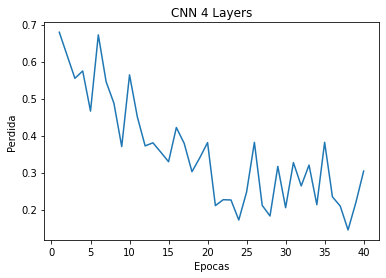

In [29]:
class CNN_4L_norm_drop2(nn.Module ):
  def __init__ (self , num_classes =4):
    super (CNN_4L_norm_drop2 , self).__init__ ()
    self. layer1 = nn.Sequential (
      nn.Conv2d ( in_channels =1, out_channels =16, kernel_size =3, stride =1, padding =2) ,
      nn.BatchNorm2d(16),
      nn.Dropout(0.5),
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self. layer2 = nn. Sequential (
      nn.Conv2d (in_channels=16, out_channels=32, kernel_size =5, stride =1, padding =2) ,
      nn.BatchNorm2d(32),
      nn.Dropout(0.5),
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self. layer3 = nn. Sequential (
      nn.Conv2d (in_channels=32, out_channels=64, kernel_size =3, stride =1, padding =2) ,
      nn.BatchNorm2d(64),
      nn.Dropout(0.5),
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self. layer4 = nn. Sequential (
      nn.Conv2d (in_channels=64, out_channels=128, kernel_size =3, stride =1, padding =2) ,
      nn.BatchNorm2d(128),
      nn.Dropout(0.5),
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self.fc = nn.Linear (2048 , num_classes )

  def forward (self , x):
    out = self. layer1 (x)
    out = self. layer2 (out)
    out = self. layer3 (out)
    out = self. layer4 (out)
    out = out. reshape (out.size (0) , -1)
    out = self.fc(out)
    return out

model         = CNN_4L_norm_drop2().to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

model.fc.weight

list_loss = train(model,optimizer,loss_fn,20, train_loader)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("CNN 4 Layers")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)



In [30]:
with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 88.02480916030534 %


Epoch [1/20], Step [100/232], Loss: 1.4182
Epoch [1/20], Step [200/232], Loss: 0.5848
Epoch [2/20], Step [100/232], Loss: 0.5920
Epoch [2/20], Step [200/232], Loss: 0.5613
Epoch [3/20], Step [100/232], Loss: 0.5009
Epoch [3/20], Step [200/232], Loss: 0.5114
Epoch [4/20], Step [100/232], Loss: 0.3163
Epoch [4/20], Step [200/232], Loss: 0.4285
Epoch [5/20], Step [100/232], Loss: 0.3646
Epoch [5/20], Step [200/232], Loss: 0.5868
Epoch [6/20], Step [100/232], Loss: 0.4162
Epoch [6/20], Step [200/232], Loss: 0.3954
Epoch [7/20], Step [100/232], Loss: 0.4003
Epoch [7/20], Step [200/232], Loss: 0.4854
Epoch [8/20], Step [100/232], Loss: 0.3990
Epoch [8/20], Step [200/232], Loss: 0.3331
Epoch [9/20], Step [100/232], Loss: 0.3075
Epoch [9/20], Step [200/232], Loss: 0.2295
Epoch [10/20], Step [100/232], Loss: 0.3108
Epoch [10/20], Step [200/232], Loss: 0.2987
Epoch [11/20], Step [100/232], Loss: 0.3067
Epoch [11/20], Step [200/232], Loss: 0.3362
Epoch [12/20], Step [100/232], Loss: 0.3113
Epoch 

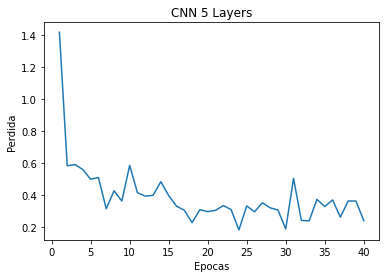

In [31]:
class CNN_5L_norm_drop2(nn.Module ):
  def __init__ (self , num_classes =4):
    super (CNN_5L_norm_drop2 , self).__init__ ()
    self. layer1 = nn.Sequential (
      nn.Conv2d ( in_channels =1, out_channels =16, kernel_size =3, stride =1, padding =2) ,
      nn.BatchNorm2d(16),
      nn.Dropout(0.5),
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self. layer2 = nn. Sequential (
      nn.Conv2d (in_channels=16, out_channels=32, kernel_size =5, stride =1, padding =2) ,
      nn.BatchNorm2d(32),
      nn.Dropout(0.5),
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self. layer3 = nn. Sequential (
      nn.Conv2d (in_channels=32, out_channels=64, kernel_size =3, stride =1, padding =2) ,
      nn.BatchNorm2d(64),
      nn.Dropout(0.5),
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self. layer4 = nn. Sequential (
      nn.Conv2d (in_channels=64, out_channels=128, kernel_size =3, stride =1, padding =2) ,
      nn.BatchNorm2d(128),
      nn.Dropout(0.5),
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self. layer5 = nn. Sequential (
      nn.Conv2d (in_channels=128, out_channels=256, kernel_size =3, stride =1, padding =2) ,
      nn.BatchNorm2d(256),
      nn.Dropout(0.5),
      nn.ReLU (),
      nn.MaxPool2d ( kernel_size =2, stride =2))
    self.fc = nn.Linear (2304 , num_classes )

  def forward (self , x):
    out = self. layer1 (x)
    out = self. layer2 (out)
    out = self. layer3 (out)
    out = self. layer4 (out)
    out = self. layer5 (out)
    out = out. reshape (out.size (0) , -1)
    out = self.fc(out)
    return out

model         = CNN_5L_norm_drop2().to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

model.fc.weight

list_loss = train(model,optimizer,loss_fn,20, train_loader)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("CNN 5 Layers")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)



In [32]:
with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 87.83396946564885 %


In [7]:
#Obtenido de https://discuss.pytorch.org/t/simple-efficient-way-to-create-dataset/65178

class AlexNetDataSet(Dataset):
    def __init__(self, array_np, transform=None):
        super(AlexNetDataSet, self).__init__()
        self.data = array_np   

    def __getitem__(self, idx):
        img = cv2.imread(self.data[idx,0],0)
        img = cv2.resize(img, (227, 227))
        x = torch.tensor(img)
        y = torch.tensor(self.data[idx,1])
        return x, y

    def __len__(self):
        return (self.data.shape[0])

x = cv2.imread(data_np[1][0], 0)
y = data_np[1][1]
X_train, X_rest, y_train, y_rest = train_test_split(data_np[:,0], data_np[:,1], test_size=0.3, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.33, shuffle=True)

train = np.c_[X_train, y_train]
validation = np.c_[X_val, y_val]
test = np.c_[X_test, y_test]

train_loader_alex = AlexNetDataSet(train)
test_loader_alex = AlexNetDataSet(test)
validation_loader_alex =  AlexNetDataSet(validation)

train_loader_alex = torch.utils.data.DataLoader(dataset=train_loader_alex, batch_size=batch_size, shuffle=True)
test_loader_alex = torch.utils.data.DataLoader(dataset=test_loader_alex, batch_size=batch_size, shuffle=False)
validation_loader_alex = torch.utils.data.DataLoader(dataset=validation_loader_alex, batch_size=batch_size, shuffle=False)


Epoch [1/20], Step [100/232], Loss: 0.8250
Epoch [1/20], Step [200/232], Loss: 0.7679
Epoch [2/20], Step [100/232], Loss: 0.5923
Epoch [2/20], Step [200/232], Loss: 0.7310
Epoch [3/20], Step [100/232], Loss: 0.6083
Epoch [3/20], Step [200/232], Loss: 0.4838
Epoch [4/20], Step [100/232], Loss: 0.5676
Epoch [4/20], Step [200/232], Loss: 0.4631
Epoch [5/20], Step [100/232], Loss: 0.4559
Epoch [5/20], Step [200/232], Loss: 0.4097
Epoch [6/20], Step [100/232], Loss: 0.4082
Epoch [6/20], Step [200/232], Loss: 0.3263
Epoch [7/20], Step [100/232], Loss: 0.3638
Epoch [7/20], Step [200/232], Loss: 0.2683
Epoch [8/20], Step [100/232], Loss: 0.5872
Epoch [8/20], Step [200/232], Loss: 0.5256
Epoch [9/20], Step [100/232], Loss: 0.7082
Epoch [9/20], Step [200/232], Loss: 0.6177
Epoch [10/20], Step [100/232], Loss: 0.3303
Epoch [10/20], Step [200/232], Loss: 0.3950
Epoch [11/20], Step [100/232], Loss: 0.2791
Epoch [11/20], Step [200/232], Loss: 0.3708
Epoch [12/20], Step [100/232], Loss: 0.2010
Epoch 

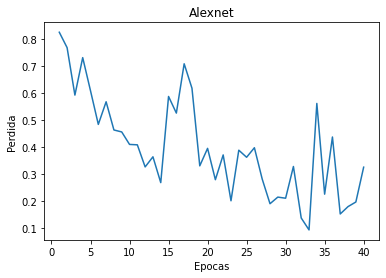

In [36]:
#https://blog.paperspace.com/alexnet-pytorch/
class AlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model         = AlexNet().to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)


list_loss = train(model,optimizer,loss_fn,20, train_loader_alex)


e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("Alexnet")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)



In [37]:
with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader_alex:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 88.88358778625954 %


In [10]:
#https://blog.paperspace.com/alexnet-pytorch/
class AlexNet_LeakyReLU(nn.Module):
    def __init__(self, num_classes=4):
        super(AlexNet_LeakyReLU, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.LeakyReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.LeakyReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.LeakyReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.LeakyReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out





In [ ]:
model         = AlexNet_LeakyReLU().to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

list_loss = train(model,optimizer,loss_fn,17, train_loader_alex)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("Alexnet Leaky Relu")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)

In [39]:

with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader_alex:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 89.2175572519084 %


Epoch [1/17], Step [100/232], Loss: 0.6638
Epoch [1/17], Step [200/232], Loss: 0.6543
Epoch [2/17], Step [100/232], Loss: 0.3950
Epoch [2/17], Step [200/232], Loss: 0.6384
Epoch [3/17], Step [100/232], Loss: 0.3768
Epoch [3/17], Step [200/232], Loss: 0.3714
Epoch [4/17], Step [100/232], Loss: 0.3333
Epoch [4/17], Step [200/232], Loss: 0.4200
Epoch [5/17], Step [100/232], Loss: 0.3851
Epoch [5/17], Step [200/232], Loss: 0.1763
Epoch [6/17], Step [100/232], Loss: 0.3255
Epoch [6/17], Step [200/232], Loss: 0.3924
Epoch [7/17], Step [100/232], Loss: 0.2723
Epoch [7/17], Step [200/232], Loss: 0.2417
Epoch [8/17], Step [100/232], Loss: 0.2129
Epoch [8/17], Step [200/232], Loss: 0.2901
Epoch [9/17], Step [100/232], Loss: 0.3098
Epoch [9/17], Step [200/232], Loss: 0.2368
Epoch [10/17], Step [100/232], Loss: 0.3567
Epoch [10/17], Step [200/232], Loss: 0.1854
Epoch [11/17], Step [100/232], Loss: 0.1496
Epoch [11/17], Step [200/232], Loss: 0.2269
Epoch [12/17], Step [100/232], Loss: 0.2260
Epoch 

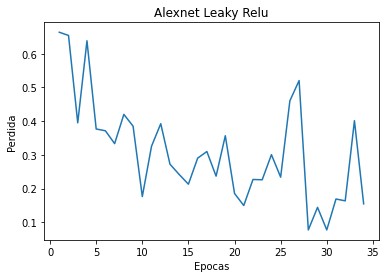

In [12]:
model         = AlexNet_LeakyReLU().to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.NAdam(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

list_loss = train(model,optimizer,loss_fn,17, train_loader_alex)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("Alexnet Leaky Relu")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)


In [13]:

with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader_alex:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 90.31488549618321 %


Epoch [1/17], Step [100/232], Loss: 0.7732
Epoch [1/17], Step [200/232], Loss: 0.5726
Epoch [2/17], Step [100/232], Loss: 0.4120
Epoch [2/17], Step [200/232], Loss: 0.4308
Epoch [3/17], Step [100/232], Loss: 0.2727
Epoch [3/17], Step [200/232], Loss: 0.3201
Epoch [4/17], Step [100/232], Loss: 0.3996
Epoch [4/17], Step [200/232], Loss: 0.3755
Epoch [5/17], Step [100/232], Loss: 0.2305
Epoch [5/17], Step [200/232], Loss: 0.3434
Epoch [6/17], Step [100/232], Loss: 0.2990
Epoch [6/17], Step [200/232], Loss: 0.2611
Epoch [7/17], Step [100/232], Loss: 0.2081
Epoch [7/17], Step [200/232], Loss: 0.3349
Epoch [8/17], Step [100/232], Loss: 0.2377
Epoch [8/17], Step [200/232], Loss: 0.1918
Epoch [9/17], Step [100/232], Loss: 0.1595
Epoch [9/17], Step [200/232], Loss: 0.2053
Epoch [10/17], Step [100/232], Loss: 0.2464
Epoch [10/17], Step [200/232], Loss: 0.1223
Epoch [11/17], Step [100/232], Loss: 0.1835
Epoch [11/17], Step [200/232], Loss: 0.1565
Epoch [12/17], Step [100/232], Loss: 0.2220
Epoch 

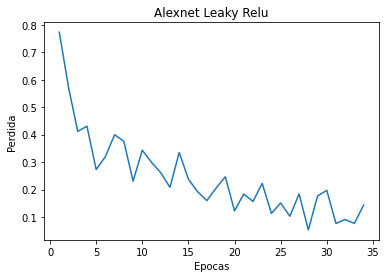

In [15]:
model         = AlexNet_LeakyReLU().to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

list_loss = train(model,optimizer,loss_fn,17, train_loader_alex)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("Alexnet Leaky Relu")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)


In [16]:

with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader_alex:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 91.45992366412214 %


Epoch [1/17], Step [100/232], Loss: 1.0631
Epoch [1/17], Step [200/232], Loss: 1.0519
Epoch [2/17], Step [100/232], Loss: 0.9622
Epoch [2/17], Step [200/232], Loss: 0.8118
Epoch [3/17], Step [100/232], Loss: 0.8907
Epoch [3/17], Step [200/232], Loss: 0.8267
Epoch [4/17], Step [100/232], Loss: 0.7322
Epoch [4/17], Step [200/232], Loss: 0.7840
Epoch [5/17], Step [100/232], Loss: 0.6133
Epoch [5/17], Step [200/232], Loss: 0.5668
Epoch [6/17], Step [100/232], Loss: 0.7023
Epoch [6/17], Step [200/232], Loss: 0.5857
Epoch [7/17], Step [100/232], Loss: 0.6146
Epoch [7/17], Step [200/232], Loss: 0.6463
Epoch [8/17], Step [100/232], Loss: 0.6804
Epoch [8/17], Step [200/232], Loss: 0.4196
Epoch [9/17], Step [100/232], Loss: 0.3692
Epoch [9/17], Step [200/232], Loss: 0.5379
Epoch [10/17], Step [100/232], Loss: 0.4114
Epoch [10/17], Step [200/232], Loss: 0.5542
Epoch [11/17], Step [100/232], Loss: 0.2894
Epoch [11/17], Step [200/232], Loss: 0.3613
Epoch [12/17], Step [100/232], Loss: 0.2761
Epoch 

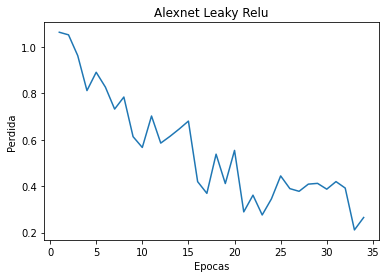

In [17]:
model         = AlexNet_LeakyReLU().to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adadelta(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

list_loss = train(model,optimizer,loss_fn,17, train_loader_alex)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("Alexnet Leaky Relu")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)


In [18]:

with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader_alex:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 85.92557251908397 %


In [13]:
#Obtenido de https://discuss.pytorch.org/t/simple-efficient-way-to-create-dataset/65178

class ModelsDataSet(Dataset):
    def __init__(self, array_np, transform=None):
        super(ModelsDataSet, self).__init__()
        self.data = array_np   

    def __getitem__(self, idx):
        img = cv2.imread(self.data[idx,0],0)
        img = cv2.resize(img, (224, 224))
        x = torch.tensor(img)
        y = torch.tensor(self.data[idx,1])
        return x, y

    def __len__(self):
        return (self.data.shape[0])

x = cv2.imread(data_np[1][0], 0)
y = data_np[1][1]
X_train, X_rest, y_train, y_rest = train_test_split(data_np[:,0], data_np[:,1], test_size=0.3, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.33, shuffle=True)

train = np.c_[X_train, y_train]
validation = np.c_[X_val, y_val]
test = np.c_[X_test, y_test]

train_loader_mod = ModelsDataSet(train)
test_loader_mod = ModelsDataSet(test)
validation_loader_mod =  ModelsDataSet(validation)

train_loader_mod = torch.utils.data.DataLoader(dataset=train_loader_mod, batch_size=batch_size, shuffle=True)
test_loader_mod = torch.utils.data.DataLoader(dataset=test_loader_mod, batch_size=batch_size, shuffle=False)
validation_loader_mod = torch.utils.data.DataLoader(dataset=validation_loader_mod, batch_size=batch_size, shuffle=False)


In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 4):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [44]:
model         = ResNet(ResidualBlock, [3,4,13,3]).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

list_loss = train(model,optimizer,loss_fn,17, train_loader_mod)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("ResNet")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:

with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader_mod:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 92.70038167938931 %


Epoch [1/17], Step [100/232], Loss: 0.7666
Epoch [1/17], Step [200/232], Loss: 0.4984
Epoch [2/17], Step [100/232], Loss: 0.3665
Epoch [2/17], Step [200/232], Loss: 0.3449
Epoch [3/17], Step [100/232], Loss: 0.2648
Epoch [3/17], Step [200/232], Loss: 0.3772
Epoch [4/17], Step [100/232], Loss: 0.2661
Epoch [4/17], Step [200/232], Loss: 0.2813
Epoch [5/17], Step [100/232], Loss: 0.1873
Epoch [5/17], Step [200/232], Loss: 0.2171
Epoch [6/17], Step [100/232], Loss: 0.2930
Epoch [6/17], Step [200/232], Loss: 0.1094
Epoch [7/17], Step [100/232], Loss: 0.2000
Epoch [7/17], Step [200/232], Loss: 0.1183
Epoch [8/17], Step [100/232], Loss: 0.2379
Epoch [8/17], Step [200/232], Loss: 0.1562
Epoch [9/17], Step [100/232], Loss: 0.0694
Epoch [9/17], Step [200/232], Loss: 0.1225
Epoch [10/17], Step [100/232], Loss: 0.0814
Epoch [10/17], Step [200/232], Loss: 0.1327
Epoch [11/17], Step [100/232], Loss: 0.2696
Epoch [11/17], Step [200/232], Loss: 0.1208
Epoch [12/17], Step [100/232], Loss: 0.1799
Epoch 

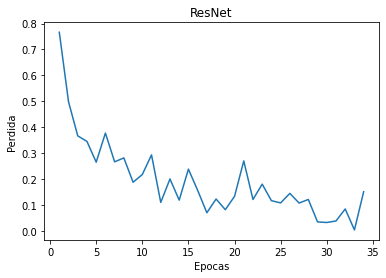

In [15]:
model         = ResNet(ResidualBlock, [3,4,6,3]).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.NAdam(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

list_loss = train(model,optimizer,loss_fn,17, train_loader_mod)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("ResNet")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)


In [16]:

with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader_mod:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 92.12786259541984 %


Epoch [1/17], Step [100/232], Loss: 1.0876
Epoch [1/17], Step [200/232], Loss: 0.9523
Epoch [2/17], Step [100/232], Loss: 0.7820
Epoch [2/17], Step [200/232], Loss: 0.7538
Epoch [3/17], Step [100/232], Loss: 0.5817
Epoch [3/17], Step [200/232], Loss: 0.5536
Epoch [4/17], Step [100/232], Loss: 0.6266
Epoch [4/17], Step [200/232], Loss: 0.4434
Epoch [5/17], Step [100/232], Loss: 0.4507
Epoch [5/17], Step [200/232], Loss: 0.4335
Epoch [6/17], Step [100/232], Loss: 0.5247
Epoch [6/17], Step [200/232], Loss: 0.3115
Epoch [7/17], Step [100/232], Loss: 0.2781
Epoch [7/17], Step [200/232], Loss: 0.3343
Epoch [8/17], Step [100/232], Loss: 0.2580
Epoch [8/17], Step [200/232], Loss: 0.1543
Epoch [9/17], Step [100/232], Loss: 0.1150
Epoch [9/17], Step [200/232], Loss: 0.1775
Epoch [10/17], Step [100/232], Loss: 0.1913
Epoch [10/17], Step [200/232], Loss: 0.0605
Epoch [11/17], Step [100/232], Loss: 0.1149
Epoch [11/17], Step [200/232], Loss: 0.1597
Epoch [12/17], Step [100/232], Loss: 0.0743
Epoch 

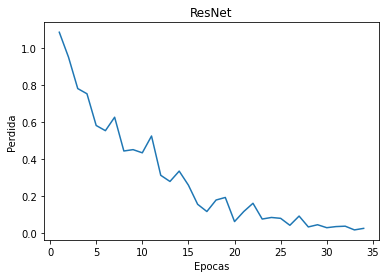

In [17]:
model         = ResNet(ResidualBlock, [3,4,6,3]).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adadelta(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

list_loss = train(model,optimizer,loss_fn,17, train_loader_mod)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("ResNet")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)


In [18]:

with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader_mod:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 86.11641221374046 %


Epoch [1/17], Step [100/463], Loss: 0.4984
Epoch [1/17], Step [200/463], Loss: 0.3663
Epoch [1/17], Step [300/463], Loss: 0.4335
Epoch [1/17], Step [400/463], Loss: 0.3315
Epoch [2/17], Step [100/463], Loss: 0.3433
Epoch [2/17], Step [200/463], Loss: 0.2544
Epoch [2/17], Step [300/463], Loss: 0.4116
Epoch [2/17], Step [400/463], Loss: 0.5917
Epoch [3/17], Step [100/463], Loss: 0.1153
Epoch [3/17], Step [200/463], Loss: 0.1853
Epoch [3/17], Step [300/463], Loss: 0.2046
Epoch [3/17], Step [400/463], Loss: 0.1396
Epoch [4/17], Step [100/463], Loss: 0.1759
Epoch [4/17], Step [200/463], Loss: 0.0976
Epoch [4/17], Step [300/463], Loss: 0.1102
Epoch [4/17], Step [400/463], Loss: 0.0850
Epoch [5/17], Step [100/463], Loss: 0.1339
Epoch [5/17], Step [200/463], Loss: 0.0905
Epoch [5/17], Step [300/463], Loss: 0.0408
Epoch [5/17], Step [400/463], Loss: 0.1277
Epoch [6/17], Step [100/463], Loss: 0.0370
Epoch [6/17], Step [200/463], Loss: 0.0272
Epoch [6/17], Step [300/463], Loss: 0.0530
Epoch [6/17

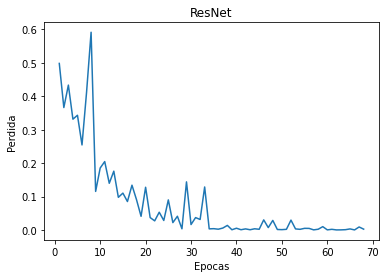

In [11]:
model         = ResNet(ResidualBlock, [3,4,6,3]).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

list_loss = train(model,optimizer,loss_fn,17, train_loader_mod)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("ResNet")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)


In [12]:

with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader_mod:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 93.03435114503817 %


In [14]:
class ResidualBlock_Leak(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock_Leak, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.LeakyReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.LeakyReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet_Leak(nn.Module):
    def __init__(self, block, layers, num_classes = 4):
        super(ResNet_Leak, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [18]:
model         = ResNet_Leak(ResidualBlock_Leak, [3,4,5,3])
model.to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

list_loss = train(model,optimizer,loss_fn,13, train_loader_mod)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("ResNet")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:

with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader_alex:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

In [ ]:
model         = ResNet_Leak(ResidualBlock_Leak, [3,4,6,3]).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.NAdam(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

list_loss = train(model,optimizer,loss_fn,13, train_loader_alex)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("ResNet")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)

In [ ]:

with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader_alex:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

In [ ]:
model         = ResNet_Leak(ResidualBlock_Leak, [3,4,6,3]).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adadelta(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

list_loss = train(model,optimizer,loss_fn,13, train_loader_alex)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("ResNet")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)

In [ ]:

with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader_alex:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

In [ ]:
model         = ResNet_Leak(ResidualBlock_Leak, [3,4,6,3]).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

list_loss = train(model,optimizer,loss_fn,13, train_loader_alex)

e = (len(list_loss))
epochs = [i + 1 for i in range(e)]
plt.title("ResNet")
plt.xlabel("Epocas")
plt.ylabel("Perdida")
plt.plot(epochs,list_loss)

In [ ]:

with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader_alex:
          images = images.to(device)
          labels = labels.to(device)
          im = torch.unsqueeze(images, dim=1)
          im = im.float()
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))